# Fake_News Classification

## *1.Import Required Libraries*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report,RocCurveDisplay
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import joblib

## *2.Load The Dataset*

In [2]:
df=pd.read_csv("D:\WELFake_Dataset.csv")
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [3]:
#check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


## *3. Data Cleaning*

In [4]:
#Drop unnecessory columns
df.drop(['Unnamed: 0','title'],axis=1,inplace=True)

In [5]:
#check the null values
df.isnull().sum()

text     39
label     0
dtype: int64

In [6]:
#Drop the null values
df.dropna(inplace=True)

## *4. Exploratory Data Analysis(EDA) perform*

In [7]:
#shape of dataset
df.shape

(72095, 2)

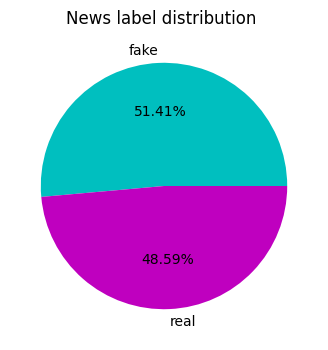

In [8]:
# pie plot of label distribution
values=df['label'].value_counts().values
plt.figure(figsize=(6,4))
plt.pie(values,autopct='%.2f%%',labels=['fake','real'],colors=['c','m'])
plt.title("News label distribution ")
plt.show()

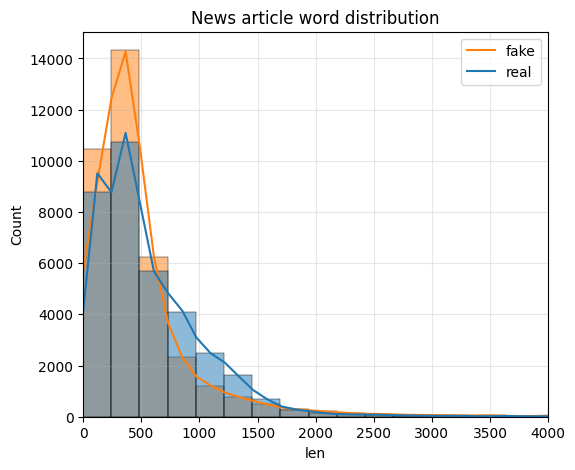

In [9]:
# plot histogram of word distribution
plt.figure(figsize=(6,5))
df['len']=df['text'].apply(lambda x: len(x.split()))
sns.histplot(data=df,x='len',bins=100,hue='label',kde=True)
plt.title("News article word distribution")
plt.grid(alpha=0.3)
plt.legend(['fake','real'])
plt.xlim(0,4000)
plt.show()

In [10]:
# Word Cloud for most frequent word
fake_text=''.join(df[df['label']==0]['text'])
real_text=''.join(df[df['label']==1]['text'])


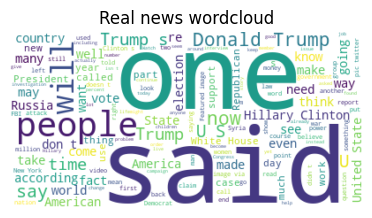

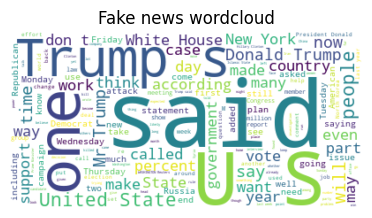

In [11]:
#Generate real news wordcloud
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
real_wc=WordCloud(background_color='white')
real_wc.generate(real_text)
plt.imshow(real_wc,interpolation='bilinear')
plt.title('Real news wordcloud')
plt.axis('off')
plt.show()

#Generate fake news wordcloud
plt.figure(figsize=(10,8))
plt.subplot(1,2,2)
fake_wc=WordCloud(background_color='white')
fake_wc.generate(fake_text)
plt.imshow(fake_wc,interpolation='bilinear')
plt.title("Fake news wordcloud")
plt.axis('off')
plt.show()

## *5. Text preprocessing*

In [13]:
# remove url,numbers,punctuation and  text lowercasing
punc=string.punctuation
def text_preprocess(text):
    cln_text=re.sub(r'https?://\s+|www\.\s+','',text)  # remove url
    cln_text=re.sub(r'\d+','',text)                     # remove numbers
    cln_text=''.join([char for char in text if char not in punc])  #remove punctuation
    return (str.lower(cln_text))                #text lower-casing

df['text']=df.text.apply(lambda x: text_preprocess(x))

In [14]:
# Tokenize and remove stopwords
sw=set(stopwords.words('english'))
def tokenization(text):
    tokens=word_tokenize(text)                              #tokenize the text
    clean_token=[word for word in tokens if word not in sw]    # stopwords removel
    return clean_token
    
df['text']=df.text.apply(lambda x: tokenization(x))

In [15]:
#lemmatization on word 
def lemmatization(text):
    lematizer=WordNetLemmatizer()
    lemma_word=[lematizer.lemmatize(word) for word in text]
    return lemma_word
df['text']=df.text.apply(lemmatization)

## *6. Text Vectorization*

In [16]:
# vectorize the text data
corpus=[' '.join(token) for token in df.text]
vectorizer=TfidfVectorizer(dtype=np.float64)
vector_data=vectorizer.fit_transform(corpus)

In [16]:
# shape of data
vector_data.shape

(72095, 356282)

## *7. Train-test-split data*

In [17]:
# define independent and dependent voriable
x=vector_data
y=df.label

In [18]:
# use 20% for testing model
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=40,)

In [19]:
# size of train data
print('x_train size=',x_train.shape)
print('y_train size=',y_train.shape)

x_train size= (57676, 356282)
y_train size= (57676,)


In [20]:
# size of test data
print('x_test size=',x_test.shape)
print('y_test size=',y_test.shape)

x_test size= (14419, 356282)
y_test size= (14419,)


## *8. Model Build And Compare*

In [21]:
# Define and compare different models

models={'Logistic Regression':LogisticRegression(),
       'Multinomial Naivebayes':MultinomialNB(),
        'Passiveaggressive Classifier':PassiveAggressiveClassifier(),
       'Randomforest Classifier':RandomForestClassifier()}
results={}
for name,model in models.items():
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    results[name]={'Accuracy':accuracy_score(y_test,y_pred),
                  'Precision':precision_score(y_test,y_pred),
                   'Recall':recall_score(y_test,y_pred),
                   'F1':f1_score(y_test,y_pred)
                  }

In [22]:
#show c omparison table
pd.DataFrame(results).T.sort_values(by='F1',ascending=False)

,Accuracy,Precision,Recall,F1
Passiveaggressive Classifier,0.965878,0.960943,0.973575,0.967217
Logistic Regression,0.947639,0.939402,0.960698,0.949930
Randomforest Classifier,0.931271,0.932664,0.934541,0.933601
Multinomial Naivebayes,0.871281,0.907318,0.836486,0.870463


### Best Model to perform Accuracy & F1 score 
Here, after training and testing the different model we find the `*passive Aggressive Classifier*` model has given the highest `accuraacy(0.965)` and `F1-score(0.967)` from all the machine learning model. We selected the passive aggressive classifier as the final model.

### Retrain The Best Model

In [23]:
best_model=PassiveAggressiveClassifier()
best_model.fit(x_train,y_train)
y_pred=best_model.predict(x_test)

## *9. Model Evaluation*

In [24]:
# show classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      6964
           1       0.96      0.97      0.97      7455

    accuracy                           0.97     14419
   macro avg       0.97      0.97      0.97     14419
weighted avg       0.97      0.97      0.97     14419



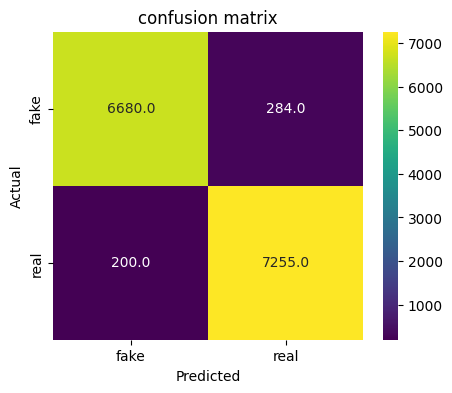

In [25]:
# plot confusion matrix
plt.figure(figsize=(5,4))
conf=confusion_matrix(y_test,y_pred)
sns.heatmap(conf,annot=True,fmt='.1f',cmap='viridis',xticklabels=['fake','real'],yticklabels=['fake','real'])
plt.title('confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<Figure size 600x500 with 0 Axes>

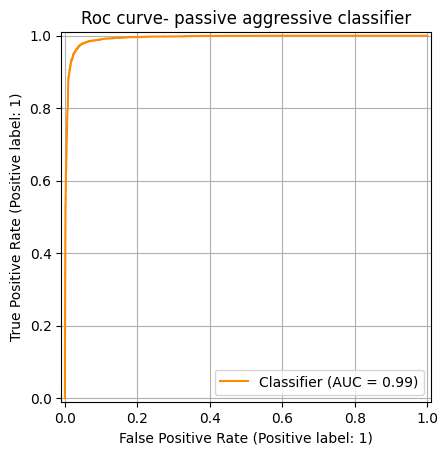

In [26]:
# Plot roc-auc curve
y_score=best_model.decision_function(x_test)
plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test,y_score,color='darkorange')
plt.title("Roc curve- passive aggressive classifier")
plt.grid()
plt.show()

## *10. Save The Model*

In [27]:
#s save the model for deployment
joblib.dump(best_model,'news_model.pkl')

['news_model.pkl']

## *11. Predict the new News* 

In [28]:
def predict_news(news):
    clean_text=text_preprocess(news)
    tokens=tokenization(clean_text)
    lemma_token=lemmatization(tokens)
    corpus=''.join([token for token in lemma_token])
    vectors=vectorizer.transform([corpus])
    prediction=best_model.predict(vectors)
    if prediction==0:
        return 'Fake News'
    else:
        return 'Real News'
    

In [29]:
# predict the news by classifier
news="One person was shot at an anti-Trump demonstration in Portland on Saturday as protesters crossed the Morrison Bridge, police said.Everyone needs to leave the area immediately, police said on Twitter, and they asked witnesses to come forward"

predict_news(news)

'Real News'